<a href="https://colab.research.google.com/github/moienr/LST-SigleChannel-SplitWindow/blob/main/automatic_LST_retrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [ ]:
!conda --version

conda 4.9.2


In [ ]:
!conda create -n geo python
!conda activate geo
!conda install geemap -c conda-forge
!conda install jupyter_contrib_nbextensions -c conda-forge
!jupyter contrib nbextension install --user

Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /usr/local/envs/geo

  added / updated specs:
    - python


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |            2_gnu          23 KB  conda-forge
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  conda-forge
    ld_impl_linux-64-2.36.1    |       hea4e1c9_2         667 KB  conda-forge
    libffi-3.4.2               |       h7f98852_5          57 KB  conda-forge
    libgcc-ng-12.1.0           |      h8d9b700_16         940 KB  conda-forge
    libgomp-12.1.0             |      h8d9b700_16         459 KB  conda-forge
    libnsl-2.0.0               |       h7f98852_0          31 KB  

In [ ]:
import os
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from collections import namedtuple

In [ ]:
def stack_3_channel(r,g,b , clipLimit = 20 ,  tileGridSize=(16,16) ):


  # r = (r/np.max(r))*255
  # g = (g/np.max(g))*255
  # b = (b/np.max(b))*255

  img = np.stack([r,g,b], axis=2)
  img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

  hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]



  clahe = cv.createCLAHE(clipLimit, tileGridSize)
  v = clahe.apply(v) #stretched histogram for showing the image with better contrast - its not ok to use it for scientific calculations

  hsv_img = np.dstack((h,s,v))

  # NOTE: HSV2RGB returns BGR instead of RGB
  bgr_stretched = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)

  #reversing the bands back to RGB
  rgb_stretched = np.zeros(bgr_stretched.shape)
  rgb_stretched[:,:,0] = bgr_stretched[:,:,2]
  rgb_stretched[:,:,1] = bgr_stretched[:,:,1]
  rgb_stretched[:,:,2] = bgr_stretched[:,:,0]

  # if the valuse are float, plt will have problem showing them
  rgb_stretched = rgb_stretched.astype('uint8')

  return img , rgb_stretched

In [ ]:
Map = geemap.Map(center=(30.529167,53.515), zoom=10)
Map.add_basemap('SATELLITE')
Map

aoi = ee.Geometry.Polygon(
    [[[53.39472, 30.520534], [53.39472, 30.608563], [53.524441, 30.608563], [53.524441, 30.520534]]], None, False
)

pin = ee.Geometry.Point((53.515,30.52916))
Map.addLayer(pin)
pin = ee.Geometry.Point((53.515,30.52916))
Map.addLayer(aoi)
Map

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8EWgSHJvRzEMMtN9suKVTwFVOV2btVTdf9Tr3tSBOzY&tc=gkxCBaWE5Wfqo6DNpVF6avZTn9rr3nBZ4VgSxheYgqY&cc=y1sZKPWh7UEMTAZgGPcgzyeCjJcDaQyg7niyB0-203I

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qhIhdTiNSUpQo4eIOQ5xHPRY2HKXXklCn4vMhShVKmh6Jv7I5pbQmU

Successfully saved authorization token.


Map(center=[30.529167, 53.515], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [ ]:
js_snippet = """
var image = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA")
  .filterBounds(roi)
  .filterDate('2020-01-01','2020-12-31')
  .sort('CLOUD_COVER')
  .first());
"""

In [ ]:
roi = ee.Geometry.Polygon(
    [[[53.437368, 30.562514], [53.437368, 30.600199], [53.481245, 30.600199], [53.481245, 30.562514]]], None, False
)

In [ ]:
lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()

image = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA") \
  .filterBounds(roi) \
  .filterDate('2020-01-01','2020-12-31') \
  .sort('CLOUD_COVER') \
  .first())
Map


In [ ]:
image = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA") \
  .filterBounds(roi) \
  .filterDate('2020-01-01','2020-12-31') \
  .sort('CLOUD_COVER') \
  .first())

In [ ]:
image.propertyNames().getInfo()

['system:version',
 'system:id',
 'RADIANCE_MULT_BAND_5',
 'RADIANCE_MULT_BAND_6',
 'RADIANCE_MULT_BAND_3',
 'RADIANCE_MULT_BAND_4',
 'RADIANCE_MULT_BAND_1',
 'RADIANCE_MULT_BAND_2',
 'K2_CONSTANT_BAND_11',
 'K2_CONSTANT_BAND_10',
 'system:footprint',
 'REFLECTIVE_SAMPLES',
 'SUN_AZIMUTH',
 'CPF_NAME',
 'DATE_ACQUIRED',
 'ELLIPSOID',
 'google:registration_offset_x',
 'google:registration_offset_y',
 'STATION_ID',
 'RESAMPLING_OPTION',
 'ORIENTATION',
 'WRS_ROW',
 'RADIANCE_MULT_BAND_9',
 'TARGET_WRS_ROW',
 'RADIANCE_MULT_BAND_7',
 'RADIANCE_MULT_BAND_8',
 'IMAGE_QUALITY_TIRS',
 'TRUNCATION_OLI',
 'CLOUD_COVER',
 'GEOMETRIC_RMSE_VERIFY',
 'COLLECTION_CATEGORY',
 'GRID_CELL_SIZE_REFLECTIVE',
 'CLOUD_COVER_LAND',
 'GEOMETRIC_RMSE_MODEL',
 'COLLECTION_NUMBER',
 'IMAGE_QUALITY_OLI',
 'LANDSAT_SCENE_ID',
 'WRS_PATH',
 'google:registration_count',
 'PANCHROMATIC_SAMPLES',
 'PANCHROMATIC_LINES',
 'GEOMETRIC_RMSE_MODEL_Y',
 'REFLECTIVE_LINES',
 'TIRS_STRAY_LIGHT_CORRECTION_SOURCE',
 'GEOMETRIC_

In [ ]:
image.get('SUN_ELEVATION').getInfo()

68.88159942626953

In [ ]:
image.get('EARTH_SUN_DISTANCE').getInfo()

1.0160218477249146

In [ ]:
image.get('system:bands').getInfo()

{'B2': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B3': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B10': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B4': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B11': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B5': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transfo

In [ ]:
image.get('system:band_names').getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA']

In [ ]:
optic = image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7'])
thermal = image.select(['B10', 'B11'])

In [ ]:
optic= geemap.ee_to_numpy(optic,region=roi)
thermal= geemap.ee_to_numpy(thermal,region=roi)

In [ ]:
optic.shape

(144, 145, 6)

In [ ]:
thermal.shape

(144, 145, 2)

# ROI

In [ ]:
def roi_create(lat = 53.0,lon = 30.0):
    marj = 0.0658155 # marjin around the point
    roi = ee.Geometry.Polygon([[[lat+marj, lon-marj], [lat+marj, lon+marj],
                              [lat-marj, lon+marj], [lat-marj, lon-marj]]], None, False)
    return roi

# 1

In [ ]:
def band_retrival(roi,start_date='2020-01-01',end_date='2020-12-31'):



  image = ee.Image(ee.ImageCollection("LANDSAT/LC08/C02/T1_RT") \
  .filterBounds(roi) \
  .filterDate(start_date,end_date) \
  .sort('CLOUD_COVER') \
  .first())
  optic = image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7'])
  thermal = image.select(['B10', 'B11'])


  optic= geemap.ee_to_numpy(optic,region=roi)
  thermal= geemap.ee_to_numpy(thermal,region=roi)
  print(image.get('DATE_ACQUIRED').getInfo())
  return {'optic':optic,'thermal':thermal,'meta':image}

In [ ]:
bands = band_retrival(roi_create(53.0,30.0),start_date='2022-07-17',end_date='2022-08-17')

2022-07-25


In [ ]:
print(bands['optic'].shape,bands['thermal'].shape)

(494, 433, 6) (494, 433, 2)


In [ ]:
rgb , stretched = stack_3_channel(bands['optic'][:,:,2],bands['optic'][:,:,1],bands['optic'][:,:,0],clipLimit = 10 ,  tileGridSize=(8,8) )
print(stretched.shape)

(494, 433, 3)


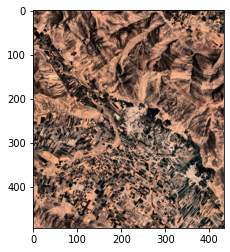

In [ ]:
plt.imshow(stretched)

In [ ]:
plt.rcParams['figure.figsize'] = [20,10]

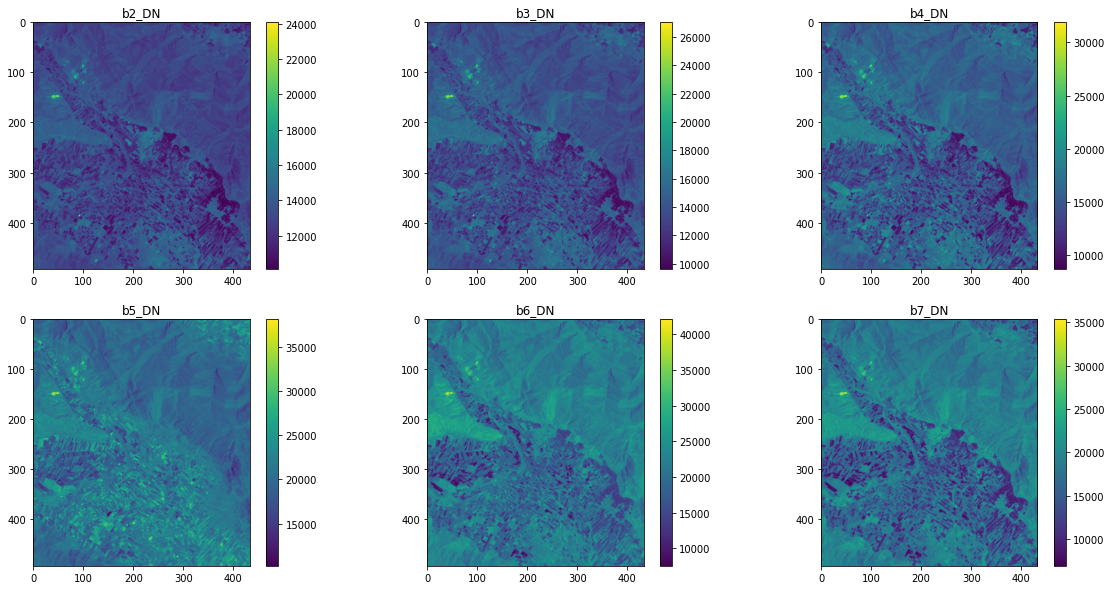

In [ ]:
fig, ax = plt.subplots(2, 3)
k = 0 # we do not need band 1
for i in range(2):
    for j in range(3):

         im = ax[i, j].imshow(bands['optic'][:,:,k])
         ax[i, j].set_title('b' + str(k+2) + '_DN')
         plt.colorbar(im, ax=ax[i, j])
         k += 1
plt.show()

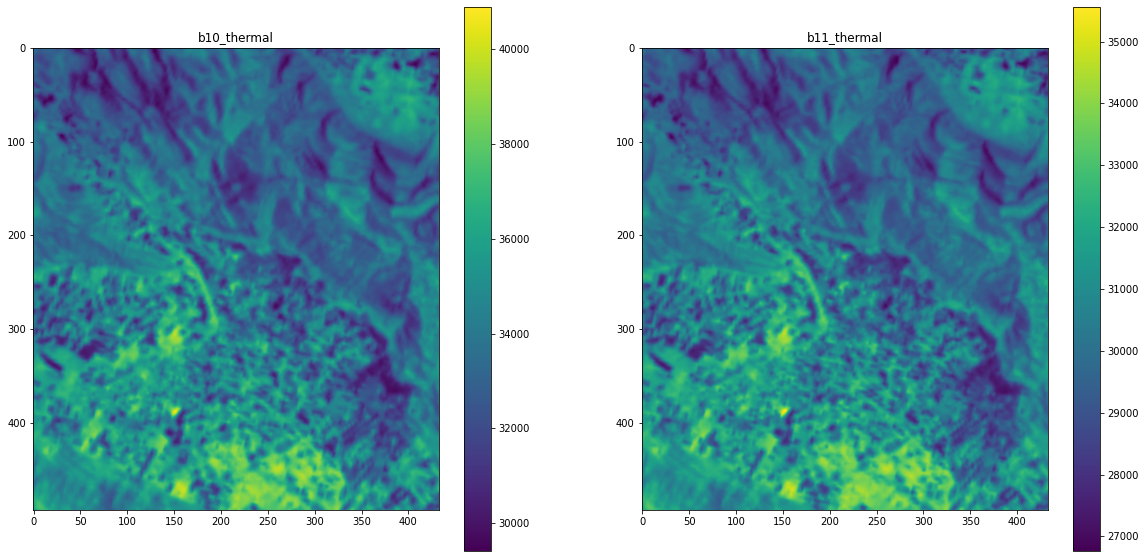

In [ ]:
fig, ax = plt.subplots(1, 2)
k = 0
for i in range(1):
    for j in range(2):

         im = ax[j].imshow(bands['thermal'][:,:,k])
         ax[j].set_title('b' + str(k+10) + '_thermal')
         plt.colorbar(im, ax=ax[j])
         k += 1
plt.show()

# 2 SRTM

In [ ]:
def srtm_retrival(roi):
  srtm = ee.Image("CGIAR/SRTM90_V4").select('elevation').clip(roi)
  proj = srtm.projection().getInfo()
  print(proj)
  srtm = geemap.ee_to_numpy(srtm,region=roi)
  print(srtm.shape)
  return srtm[:,:,0]

In [ ]:
srtm = srtm_retrival(roi_create(53.0,30.0))

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.000833333333333, 0, -180, 0, -0.000833333333333, 60]}
(158, 158, 1)


1604 1833.8064813331198 253.67903374059625 2567


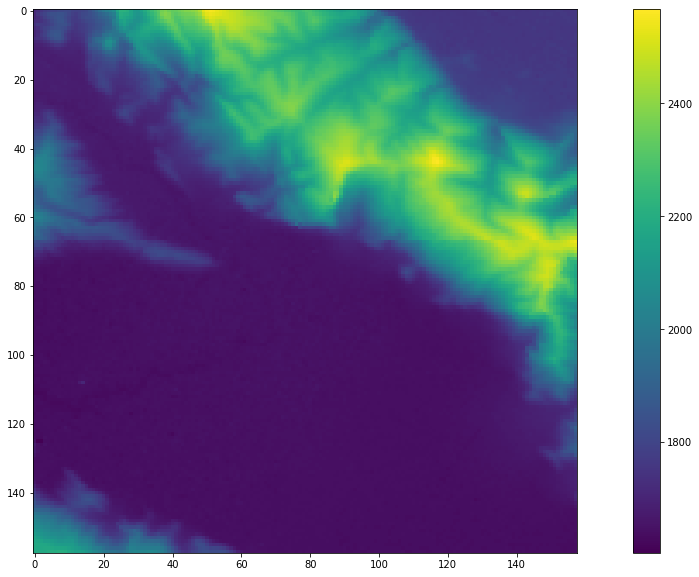

In [ ]:
plt.imshow(srtm)
plt.colorbar()
print(np.min(srtm),np.mean(srtm),np.std(srtm),np.max(srtm))

In [ ]:
def b10_dn2radiance(dn_raster,metadata):
  gain = metadata.get('RADIANCE_MULT_BAND_10').getInfo()
  bias = metadata.get('RADIANCE_ADD_BAND_10').getInfo()
  radiance = gain*dn_raster + bias
  return radiance

In [ ]:
b10_rad = b10_dn2radiance(bands['thermal'][:,:,0],bands['meta'])

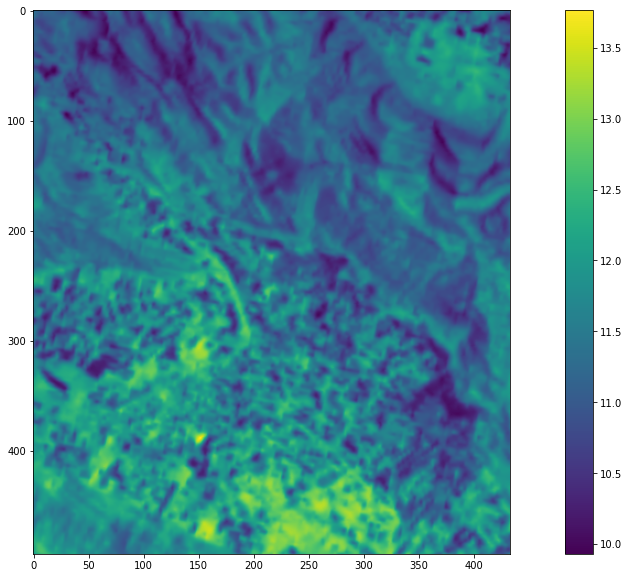

In [ ]:
plt.imshow(b10_rad)
plt.colorbar()

In [ ]:
def dn2reflectance(dn_raster_stack,metadata):
  """Caclulates Reflectance - NOTE: for landsat 8 Gain and offset is the same for all bands so, you can leave it as defualt unless you know this has changed"""
  sun_elev = metadata.get('SUN_ELEVATION').getInfo()
  ref_stack = np.zeros(dn_raster_stack.shape)
  for i in range(dn_raster_stack.shape[2]):
    dn_raster = dn_raster_stack[:,:,i]
    gain = metadata.get('REFLECTANCE_MULT_BAND_'+str(i+2)).getInfo()
    bias = metadata.get('REFLECTANCE_ADD_BAND_'+str(i+2)).getInfo()
    reflectance = (gain*dn_raster + bias)/ np.sin(np.radians(sun_elev))
    reflectance [reflectance>0.99] = 0.99
    ref_stack[:,:,i] = reflectance


  return ref_stack

In [ ]:
refl_stack = dn2reflectance(bands['optic'],bands['meta'])

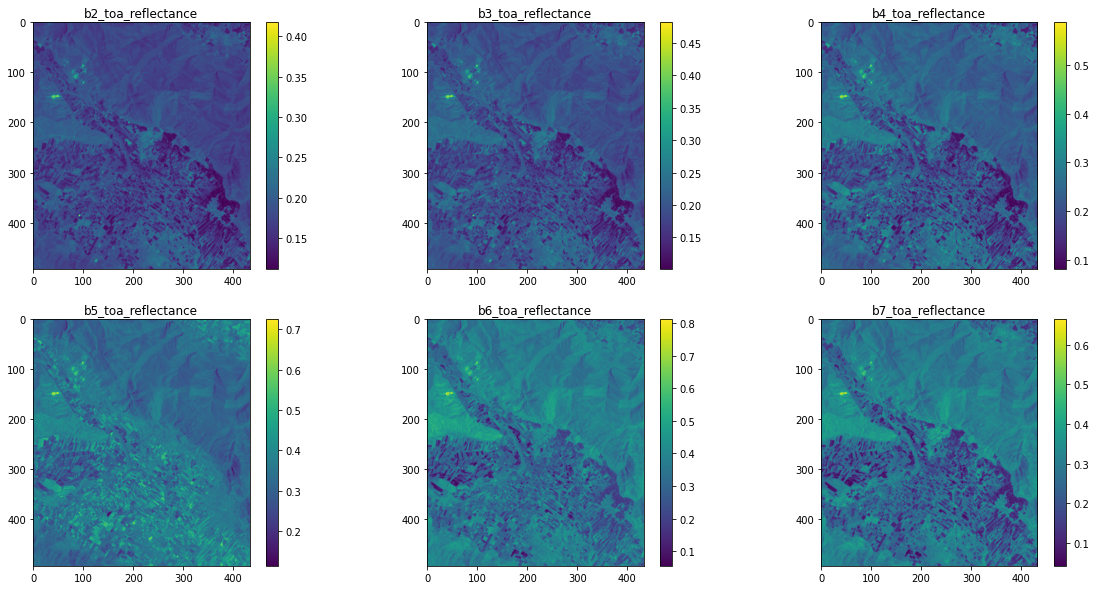

In [ ]:
fig, ax = plt.subplots(2, 3)
k = 0 # we do not need band 1
for i in range(2):
    for j in range(3):

         im = ax[i, j].imshow(refl_stack[:,:,k])
         ax[i, j].set_title('b' + str(k+2) + '_toa_reflectance')
         plt.colorbar(im, ax=ax[i, j])
         k += 1
plt.show()

## NDVI

NDVI $=\left(\rho_{5}-\rho_{4}\right) /\left(\rho_{5}+\rho_{4}\right)$

the negative values we are getting for our NDVI are because of the muddyness of the ponds which makes them have reflectance in RED but not in NIR.(?)

In [ ]:
ndvi = (refl_stack[:,:,3] - refl_stack[:,:,2])/(refl_stack[:,:,3] + refl_stack[:,:,2])

0.2021483894478059


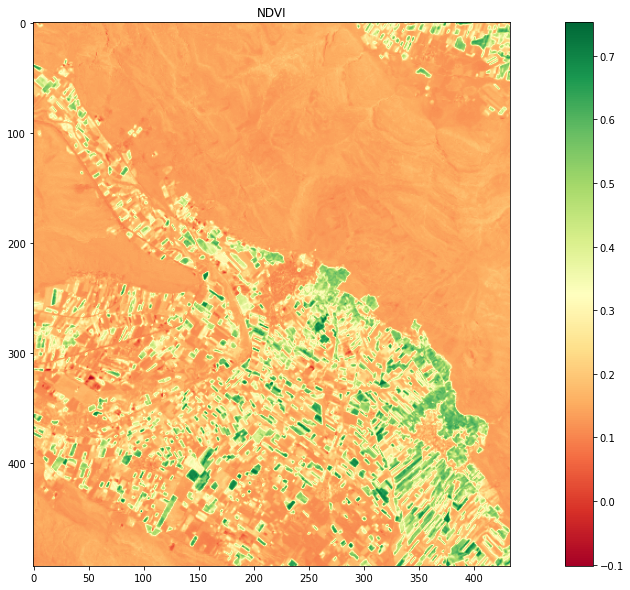

In [ ]:
print(np.mean(ndvi))
plt.imshow(ndvi,cmap='RdYlGn')
plt.title('NDVI')
plt.colorbar()

## SAVI

$\mathrm{SAVI}=(1+\mathrm{L})\left(\rho_{5}-\rho_{4}\right) /\left(\mathrm{L}+\rho_{5}+\rho_{4}\right)$


L is a constant for SAVI. If L is zero, SAVI becomes equal to NDVI. A value of 0.5 frequently appears in the literature for L. However, a value of 0.1 is used to better 19
represent soils of southern Idaho.

In [ ]:
L = 0.1
savi = (1+L)*(refl_stack[:,:,3] - refl_stack[:,:,2])/(L+refl_stack[:,:,3] + refl_stack[:,:,2])

0.188773092166388
0.7177286634957901


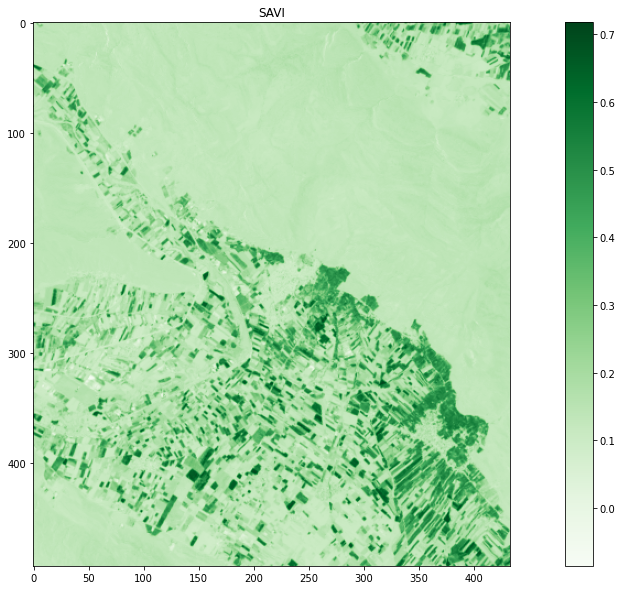

In [ ]:
print(np.mean(savi))
print(np.max(savi))
plt.imshow(savi,cmap='Greens')
plt.title('SAVI')
plt.colorbar()

## LAI

$L A I=-\frac{\ln \left(\frac{0.69-S A V I_{I D}}{0.59}\right)}{0.91}$

for `SAVI` values `equal or greater than 0.69` the out put of logrithm is `NaN` and since these values mean high vegetataion density, we set the `log` to `6`. the max value defined in SEBAL manual, which results in `LAI` being `6.5`

(the `-` behind 6 is becauase log of numbers below 0 is negative, an it is compensated in the last line.)

In [ ]:
log = np.log((0.69 - savi)/0.59)
log[np.isnan(log)] = -6
lai = -(log/0.91)


-0.30033270917894017 0.22577464130640185


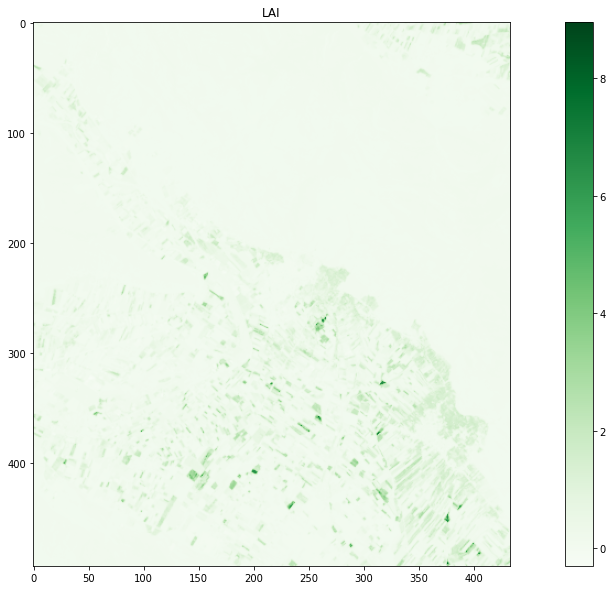

In [ ]:
print(np.min(lai),np.mean(lai))
plt.imshow(lai,cmap='Greens')
plt.title('LAI')
plt.colorbar()

In [ ]:
print(ndvi.shape)
enb = np.zeros(ndvi.shape)
e0 = np.zeros(ndvi.shape)

(494, 433)


In [ ]:
esuns = [2019.7796562748765, 1861.2746436967318, 1569.3829080742305, 960.3460702960608, 238.83526269500877, 80.50105302300764]


In [ ]:
esuns_sum = sum(esuns)
reflectances = [refl_stack[:,:,0],refl_stack[:,:,1],refl_stack[:,:,2],refl_stack[:,:,3],refl_stack[:,:,4],refl_stack[:,:,5]]
albedo_toa = np.zeros(refl_stack[:,:,0].shape)
for esun,ref in zip(esuns,reflectances):
  albedo_toa += (esun/esuns_sum)*ref
  print('esun weight',(esun/esuns_sum))


esun weight 0.30011051483506446
esun weight 0.276558925541162
esun weight 0.23318796733707178
esun weight 0.14269376002525627
esun weight 0.03548752133703651
esun weight 0.011961310924408955


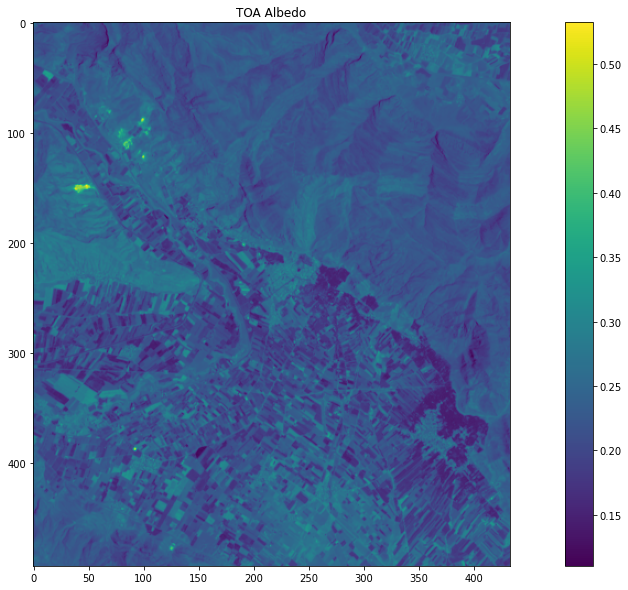

In [ ]:
plt.imshow(albedo_toa)
plt.title('TOA Albedo')
plt.colorbar()

### surface albedo form Level 1

$\alpha=\frac{\alpha_{\text {toa }}-\alpha_{\text {path_radiance }}}{\tau_{s w}^{2}}$

 "*Values for `αpath_radiance` range between 0.025 and 0.04 and for SEBAL we recommend a
value of `0.03` based on Bastiaanssen (2000).*"

τsw
is the atmospheric transmissivity.

$\tau_{\mathrm{sw}}=0.75+2 \times 10^{-5} \times \mathrm{z}$

where; `z` is the elevation above sea level (m).



In [ ]:
refl_stack[:,:,0].shape

(494, 433)

cv resize need values to be `uint8` but that screw the range, if figured out that it works well on normalized data as well so I normalized the dem between 0 and then rescaled it again by multiplying at np.max

In [ ]:
maxi = np.max(srtm)
srtm_normal = srtm/maxi
srtm_rs = cv.resize(srtm_normal, (refl_stack[:,:,0].shape[1],refl_stack[:,:,0].shape[0]))
srtm_rs = srtm_rs * maxi

1605.6415554786772 1833.8067780263832 253.46000631158614 2563.1610784377895


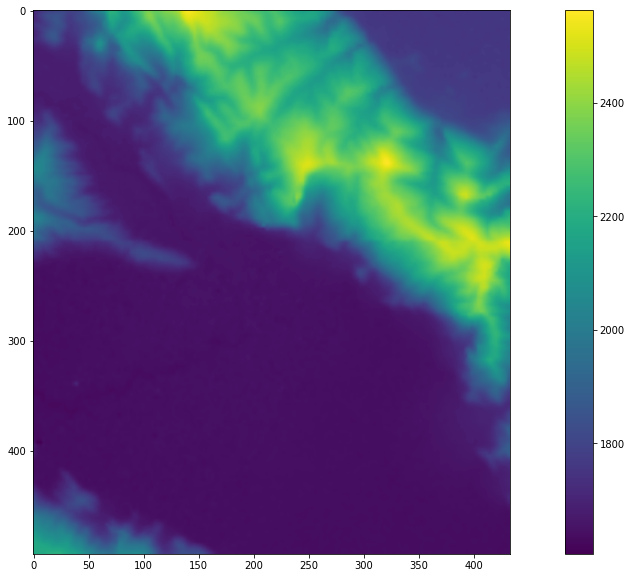

In [ ]:
plt.imshow(srtm_rs)
plt.colorbar()
print(np.min(srtm_rs),np.mean(srtm_rs),np.std(srtm_rs),np.max(srtm_rs))

In [ ]:
srtm_rs.shape

(494, 433)

#### atmospheric transmissivity

since our area is flat, elevation doesn't have a great effect on the atmospheric transmissivity reasults

In [ ]:
taw = 0.75 + 2E-5 * srtm_rs

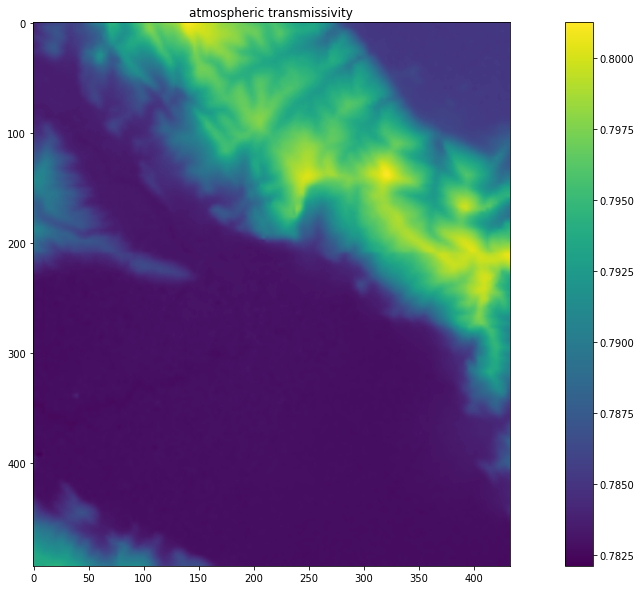

In [ ]:
plt.imshow(taw)
plt.title('atmospheric transmissivity')
plt.colorbar()

In [ ]:
surface_albedo = (albedo_toa - 0.03)/taw**2

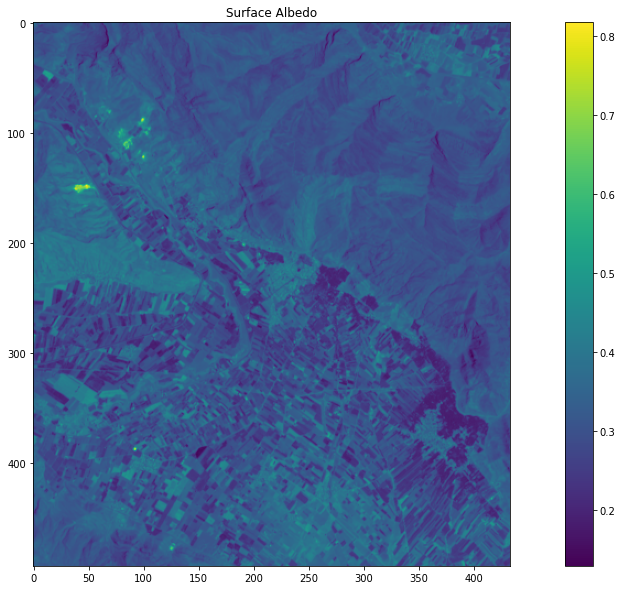

In [ ]:
plt.imshow(surface_albedo)
plt.title('Surface Albedo')
plt.colorbar()

In [ ]:
enb[np.logical_and(ndvi>0, lai<3)] = 0.97+0.0033*lai[np.logical_and(ndvi>0, lai<3)]
e0[np.logical_and(ndvi>0 , lai<3)] = 0.95+0.01*lai[np.logical_and(ndvi>0 , lai<3)]


enb[np.logical_and(ndvi>0 , lai>=3)] = 0.98
e0 [np.logical_and(ndvi>0 , lai>=3)] = 0.98

enb[np.logical_and(ndvi<=0 , surface_albedo<0.47)] = 0.99
e0 [np.logical_and(ndvi<=0 , surface_albedo<0.47)] = 0.985

enb[np.logical_and(ndvi<=0 , surface_albedo>=0.47)] = 0.99
e0 [np.logical_and(ndvi<=0 , surface_albedo>=0.47)] = 0.985

0.9707415124470148


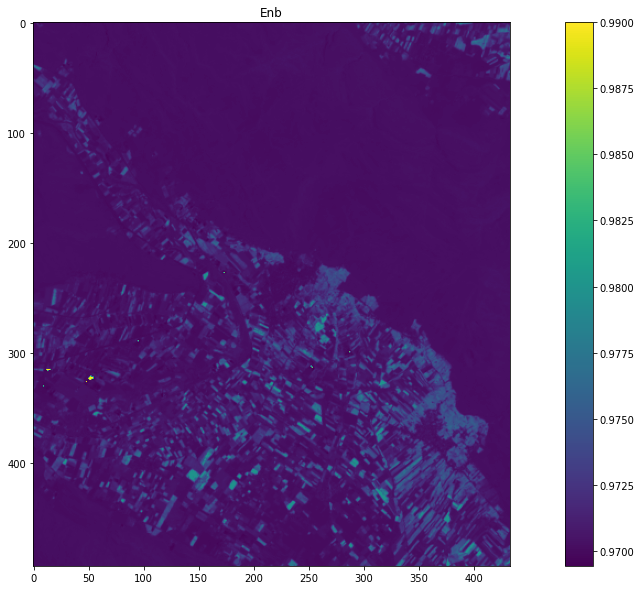

In [ ]:
print(np.mean(enb))
plt.imshow(enb)
plt.title('Enb')
plt.colorbar()

## LST (Ts)

$\mathrm{T}_{\mathrm{s}}=\frac{\mathrm{K}_{2}}{\ln \left(\frac{\varepsilon_{\mathrm{NB}} \mathrm{K}_{1}}{\mathrm{R}_{\mathrm{c}}}+1\right)}$

In [ ]:
def lst_cal(b10_radiance,enb,metadata):
  rc = b10_radiance
  K1 = metadata.get('K1_CONSTANT_BAND_10').getInfo()
  K2 = metadata.get('K2_CONSTANT_BAND_10').getInfo()
  inside_log = ((enb * K1) / rc) + 1
  Ts = K2 / np.log(inside_log)
  return Ts

In [ ]:
lst = lst_cal(b10_rad,enb,bands['meta'])

314.48853882196283


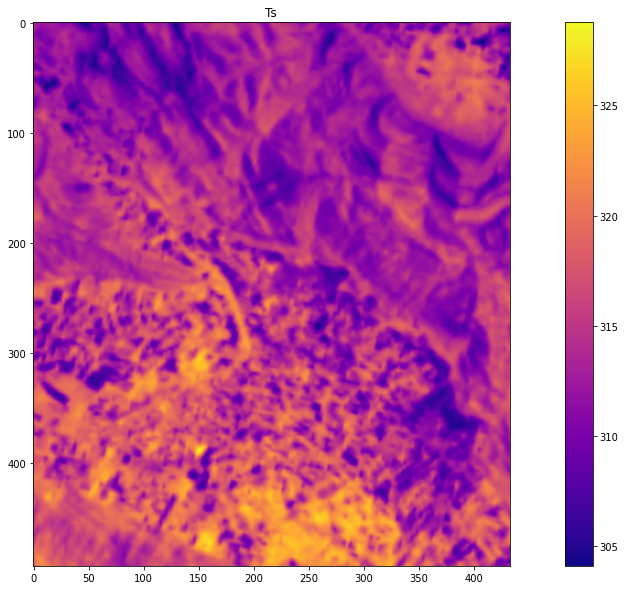

In [ ]:
print(np.mean(lst))
plt.imshow(lst,cmap='plasma')
plt.title('Ts')
plt.colorbar()

# all together

In [ ]:
image.get('system:bands').getInfo()

{'B2': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B3': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B10': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B4': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B11': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transform': [30, 0, 634485, 0, -30, 3470415]},
 'B5': {'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7551, 7701],
  'crs': 'EPSG:32639',
  'crs_transfo

In [ ]:
crs = bands['meta'].get('system:bands').getInfo()["B2"]["crs"]
print(crs)

EPSG:32639


In [ ]:
transfrom = bands['meta'].get('system:bands').getInfo()["B2"]["crs_transform"]
print(transfrom)

[30, 0, 633285, 0, -30, 3470415]


In [ ]:
proj = bands['meta'].select('B2').projection().getInfo()

In [ ]:
crs = proj['crs']
transform = proj['transform']

In [ ]:
lst_expnd_dim = np.expand_dims(lst, axis=0)
print(lst_expnd_dim.shape)

(1, 494, 433)


In [ ]:
lst_unit = lst_expnd_dim.astype('uint8')

In [ ]:
# Test with only one band:
img = geemap.numpy_to_ee(lst_expnd_dim, crs=crs, transform=transfrom, band_names='lst')

In [ ]:
data = np.dstack([lst[0:50,0:50], lst[0:50,0:50], lst[0:50,0:50]])

In [ ]:
data.shape

(50, 50, 3)

In [ ]:
type(img)

ee.image.Image

In [ ]:
img_multi = geemap.numpy_to_ee(
    data,
    crs='EPSG:4326',
    transform=[14.5, 0, -125, 0, -8, 49],
    band_names=['a', 'b', 'c'],
)

In [ ]:
import sys
sys.setrecursionlimit(15000)

In [ ]:
#@title Default title text
# Add images to a map
Map = geemap.Map(center=(30.0,53.0), zoom=13)
Map.addLayer(img)
# Map.center_object(c, zoom=13)
#Map.addLayer(img_multi, {'min': 270, 'max': 350, 'bands': ['a', 'b', 'c']})
# Map.add_basemap('SATELLITE')
Map

Map(center=[30.0, 53.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [ ]:
def realtime_lst(loc=(53.0,30.0) , start_date='2020-01-01',end_date='2020-12-31'):
  lat,lon = loc
  roi = roi_create(lat,lon)
  bands = band_retrival(roi,start_date,end_date)

  srtm = srtm_retrival(roi)

  b10_rad = b10_dn2radiance(bands['thermal'][:,:,0],bands['meta'])

  refl_stack = dn2reflectance(bands['optic'],bands['meta'])

  ndvi = (refl_stack[:,:,3] - refl_stack[:,:,2])/(refl_stack[:,:,3] + refl_stack[:,:,2])
  L = 0.1
  savi = (1+L)*(refl_stack[:,:,3] - refl_stack[:,:,2])/(L+refl_stack[:,:,3] + refl_stack[:,:,2])

  log = np.log((0.69 - savi)/0.59)
  log[np.isnan(log)] = -6
  lai = -(log/0.91)


  esuns = [2019.7796562748765, 1861.2746436967318, 1569.3829080742305, 960.3460702960608, 238.83526269500877, 80.50105302300764]
  esuns_sum = sum(esuns)
  reflectances = [refl_stack[:,:,0],refl_stack[:,:,1],refl_stack[:,:,2],refl_stack[:,:,3],refl_stack[:,:,4],refl_stack[:,:,5]]
  albedo_toa = np.zeros(refl_stack[:,:,0].shape)
  for esun,ref in zip(esuns,reflectances):
    albedo_toa += (esun/esuns_sum)*ref
    print('esun weight',(esun/esuns_sum))

  maxi = np.max(srtm)
  srtm_normal = srtm/maxi
  srtm_rs = cv.resize(srtm_normal, (refl_stack[:,:,0].shape[1],refl_stack[:,:,0].shape[0]))
  srtm_rs = srtm_rs * maxi


  taw = 0.75 + 2E-5 * srtm_rs
  surface_albedo = (albedo_toa - 0.03)/taw**2


  enb[np.logical_and(ndvi>0, lai<3)] = 0.97+0.0033*lai[np.logical_and(ndvi>0, lai<3)]
  enb[np.logical_and(ndvi>0 , lai>=3)] = 0.98
  enb[np.logical_and(ndvi<=0 , surface_albedo<0.47)] = 0.99
  enb[np.logical_and(ndvi<=0 , surface_albedo>=0.47)] = 0.99

  lst = lst_cal(b10_rad,enb,bands['meta'])



  return lst , bands['meta'] , roi


In [ ]:
a,b,c =realtime_lst()

2020-06-17
{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.000833333333333, 0, -180, 0, -0.000833333333333, 60]}
(158, 158, 1)
esun weight 0.30011051483506446
esun weight 0.276558925541162
esun weight 0.23318796733707178
esun weight 0.14269376002525627
esun weight 0.03548752133703651
esun weight 0.011961310924408955


In [ ]:
c

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              53.0658155,
              29.9341845
            ],
            [
              53.0658155,
              30.0658155
            ],
            [
              52.9341845,
              30.0658155
            ],
            [
              52.9341845,
              29.9341845
            ]
          ]
        ]
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

In [ ]:
s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
.filterDate('2020-06-01', '2020-7-01') \
.filterBounds(aoi) \
.filterMetadata('orbitProperties_pass', 'equals', 'ASCENDING')
